# Datasets and PyTorch

As we saw during the [PyTorch Tutorial](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/notebooks/pytorch_cnn.ipynb), dataset management is a large part of training neural networks.

This notebook will walk you through the fundamentals of how to create _custom_ datasets in PyTorch, and will give you an example of a custom dataset for PyTorch.

## Extending `Dataset`

The `Dataset` ([docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) class is the fundamental building block for all datasets. It represents a collection of data to use in training deep learning models. At their surface, `Dataset` looks similar to a Python list, but can be customized extensively for better performance.

Below we'll create an _outline_ for a custom dataset to give you an idea for what it looks like.

In [1]:
import torch

class RvFDataset(torch.utils.data.Dataset):
    def __init__(self):
        pass

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        pass

Let's break down what's happening the code above by step
1. **Define the custom dataset** - The first line says that `RvFDataset` is a _type_ of dataset that follows the requirements of the original `torch.utils.data.Dataset`
   ```python
   class RvFDataset(torch.utils.data.Dataset)
   ```
2. **Create a constructor** - The `__init__` function tells Python _how_ to create the dataset. Here is where we would
    - define any necessary variables (for example, metadata about the images in our dataset)
    - create any **image preprocessing** functions (for example, cropping or grayscaling images)
3. **Define how to fetch an training example** - The `__getitem__` function tells PyTorch how to get a **training example** from the dataset. We define a training example as the combination of an image and a label.

That's all! As long as you implement the `__init__` and `__getitem__` functions, you will have your own dataset!

### Offical RvF Dataset

Of course, the example above is very limited with no actual code. Below we have a full example - this is the dataset that you will be using to load all the data for this project!

We didn't have you implement all of the code for this dataset as some of the concepts are advanced and add extra complexity to an already challenging project.

That said - If you have any questions about what the code above is doing, feel free to ask the project leads!

In [2]:
from pathlib import Path
from typing import Union, Callable
import pandas as pd
import torch
import numpy.typing as npt
import torchvision
import imageio.v3 as iio

class RvFDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            split: str = "train",
            data_directory : Union[str, Path] = "data/rvf10k",
            preprocessor : Callable[[npt.ArrayLike], torch.Tensor] = None
    ):
        self.data_directory = Path(data_directory)
        self.metadata = pd.read_csv(self.data_directory / f"{split}.csv")

        if preprocessor is None:
            self.preprocessor = torchvision.transforms.ToTensor()
        else:
            self.preprocessor = preprocessor

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        image_metadata = self.metadata.iloc[index]
        path = self.data_directory / image_metadata["path"]
        image = self.preprocessor(iio.imread(path))
        return image, image_metadata["label"]


## Batching and Data Loading

As mentioned in the PyTorch tutorial, we often want to train a (supervised) machine learning model using an algorithm called [mini-batch SGD](https://developers.google.com/machine-learning/crash-course/reducing-loss/stochastic-gradient-descent)

PyTorch provides the `DataLoader` ([docs](https://pytorch.org/docs/stable/data.html?highlight=data+loader#torch.utils.data.DataLoader)) to prepare data into batches for training neural networks.

Let's see an example of a data loader in practice!

🚨 **WARNING** 🚨: The following code will not work unless you have the `rvf10k` dataset downloaded. The code below will download the dataset if you do not have it downloaded already.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Change this to the folder containing your Kaggle API key (kaggle.json)
# %env KAGGLE_KEY_FOLDER=MDST/RvF
# !mkdir data
# !export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/$KAGGLE_KEY_FOLDER && wget -O - "https://raw.githubusercontent.com/MichiganDataScienceTeam/W24-RvF/main/data/download.sh" | bash -s rvf10k

Let's create an instance of our RvF Dataset below and wrap it in a `DataLoader` object.

In [5]:
train_dataset = RvFDataset("train", data_directory="../data/rvf5k")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = RvFDataset("valid", data_directory="../data/rvf5k")
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

Let's break down the settings we just passed in to create the DataLoader:
- `train_dataset` - this is the dataset object we want to wrap and load batches from
- `batch_size` - this describes how many training examples we'd like to include in a single batch
- `shuffle` - tells the data loader to _shuffle_ the images when selecting them. Keep this enabled for training data loaders, but disable this for testing data loaders.

If we take a look at the data loaders, we can see indeed that the loaded data contains a _batch_ of training examples

In [6]:
batch = next(iter(train_loader)) # don't worry about this magic for now
print(f"Shape of batch of images: {batch[0].shape}")
print(f"Shape of batch of labels: {batch[1].shape}")

Shape of batch of images: torch.Size([32, 3, 256, 256])
Shape of batch of labels: torch.Size([32])


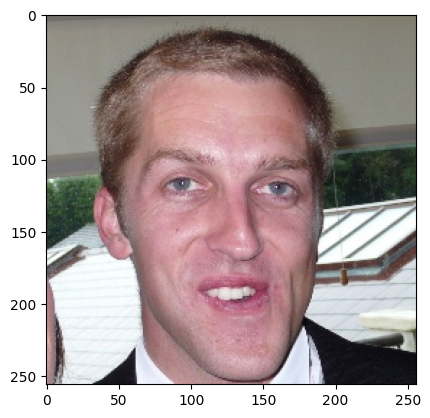

tensor(1)


In [17]:
# Display an image form the batch
import matplotlib.pyplot as plt
plt.imshow(batch[0][7].permute(1, 2, 0))
plt.show()
print(batch[1][7])